In [101]:
import pymongo
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Inicializar

In [2]:
cliente = pymongo.MongoClient()

In [3]:
cliente.list_database_names()

['admin', 'companies_db', 'config', 'local']

In [4]:
db = cliente.companies_db

In [5]:
db.collection_names()

<ipython-input-5-8ff4d2505e25>:1: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  db.collection_names()


['companies']

In [6]:
colec = db.companies

## Exploración de la base de datos

In [7]:
document = list(colec.find().limit(1))

In [8]:
document[0].keys()

dict_keys(['_id', 'name', 'permalink', 'crunchbase_url', 'homepage_url', 'blog_url', 'blog_feed_url', 'twitter_username', 'category_code', 'number_of_employees', 'founded_year', 'founded_month', 'founded_day', 'deadpooled_year', 'tag_list', 'alias_list', 'email_address', 'phone_number', 'description', 'created_at', 'updated_at', 'overview', 'image', 'products', 'relationships', 'competitions', 'providerships', 'total_money_raised', 'funding_rounds', 'investments', 'acquisition', 'acquisitions', 'offices', 'milestones', 'video_embeds', 'screenshots', 'external_links', 'partners'])

In [9]:
# total de compañías
len(list(colec.find()))

18801

## Extracción de la información general de las compañías

In [10]:
# Filtros:
# compañías con número de empleados > 0

# Diccionario con las llaves de interés
dic_gen_com= {'name':1, 'homepage_url':1, 'category_code':1, 'number_of_employees':1, 
          'founded_year':1, 'founded_month':1, 'founded_day':1, 'description':1, 'total_money_raised':1, 
            'deadpooled_year':1}



In [11]:
# Número de compañías con número de empleados > 0
len(list(colec.find({'number_of_employees':{'$gte':0}}, dic_gen_com)))

8889

In [12]:
data_com = list(colec.find({'number_of_employees':{'$gte':0}}, dic_gen_com))

In [13]:
data_com[0]

{'_id': ObjectId('52cdef7c4bab8bd675297d8a'),
 'name': 'Wetpaint',
 'homepage_url': 'http://wetpaint-inc.com',
 'category_code': 'web',
 'number_of_employees': 47,
 'founded_year': 2005,
 'founded_month': 10,
 'founded_day': 17,
 'deadpooled_year': 1,
 'description': 'Technology Platform Company',
 'total_money_raised': '$39.8M'}

In [14]:
df_gen_com = pd.json_normalize(data_com)
df_gen_com.drop_duplicates(inplace=True)

In [15]:
df_gen_com.head()

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised
0,52cdef7c4bab8bd675297d8a,Wetpaint,http://wetpaint-inc.com,web,47,2005.0,10.0,17.0,1.0,Technology Platform Company,$39.8M
1,52cdef7c4bab8bd675297d8b,AdventNet,http://adventnet.com,enterprise,600,1996.0,NaN,NaN,2.0,Server Management Software,$0
2,52cdef7c4bab8bd675297d8c,Zoho,http://zoho.com,software,1600,2005.0,9.0,15.0,3.0,Online Business Apps Suite,$0
3,52cdef7c4bab8bd675297d8d,Digg,http://www.digg.com,news,60,2004.0,10.0,11.0,NaN,user driven social content website,$45M
4,52cdef7c4bab8bd675297d8e,Facebook,http://facebook.com,social,5299,2004.0,2.0,1.0,NaN,Social network,$2.43B


Observamos que en la columna 'total_money_raised', los valores corresponden a tipo string, asimismo, existen compañías con recaudaciones = 0. A continuación se filtran las compañías con recaudación mayor a 0 y se tranforma a columna numérica.

In [16]:
# Observamos a que moneda corresponden
df_gen_com['total_money_raised'].str[0].value_counts()

$    8657
€     142
£      67
C      18
¥       4
k       1
Name: total_money_raised, dtype: int64

In [17]:
8657/8889

0.9739003262459219

El 97.4% de las compañías presentan recaudación en dólares.

In [18]:
# Filtramos las compañías que tengan sus montos en dólares
df_gen_com = df_gen_com[ df_gen_com['total_money_raised'].str[0] == '$']

In [19]:
df_gen_com.shape[0]

8657

In [20]:
df_gen_com['total_money_raised'].str[-1:].value_counts()

0    6636
M    1553
k     463
B       5
Name: total_money_raised, dtype: int64

In [21]:
def total_money_raised(x):
    """Función que recibe una cantidad como string, por ejemplo: $37.7M, y devuelve dicha cantidad como numero:
    37 700 000"""
    
    if x[-1] == '0': # Casos cuando la cantidad es 0
        return 0
    elif x[-1] == 'k':
#         return float(re.findall('\d.*\d', x)[0])  * 1000
        return float(x[1:-1]) * 1000 # Casos cuando la cantidad viene en miles
    elif x[-1] == 'M':
        return float(x[1:-1]) * 1000000 # Casos cuando la cantidad viene en millones
#         return float(re.findall('\d.*\d', x)[0]) * 1000000
    elif x[-1] == 'B':
        return float(x[1:-1]) * 1000000000 # Casos cuando la cantidad viene en millones    
#         return float(re.findall('\d.*\d', x)[0]) * 1000000

In [22]:
# La columna corresponde a millones de dólares
df_gen_com['total_money_raised_num'] = df_gen_com['total_money_raised'].apply(lambda x: total_money_raised(x))
df_gen_com['total_money_raised_num'] = df_gen_com['total_money_raised_num']/1000000

In [23]:
# Filtramos aquellas cuya recaudación sea mayor a cero 
df_gen_com = df_gen_com[ df_gen_com['total_money_raised_num'] > 0]
df_gen_com.shape[0]

2021

In [24]:
df_gen_com.sort_values(by=['total_money_raised_num'], ascending=False, inplace=True)

In [25]:
df_gen_com.head()

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised,total_money_raised_num
4,52cdef7c4bab8bd675297d8e,Facebook,http://facebook.com,social,5299,2004.0,2.0,1.0,NaN,Social network,$2.43B,2430.0
7,52cdef7c4bab8bd675297d94,Twitter,http://twitter.com,social,1300,2006.0,3.0,21.0,NaN,Real time communication platform,$1.16B,1160.0
4166,52cdef7d4bab8bd675299d5d,Groupon,http://www.groupon.com,web,10000,2008.0,11.0,11.0,NaN,Local Daily Deals,$1.15B,1150.0
2203,52cdef7d4bab8bd675298ee5,Xerox,http://www.xerox.com,hardware,57400,1906.0,NaN,NaN,NaN,,$1.1B,1100.0
161,52cdef7c4bab8bd675297e96,AOL,http://www.aol.com,web,8000,1985.0,5.0,24.0,NaN,,$1B,1000.0


In [26]:
# Filtrar empresas cuyo número de empleados sea 0
df_gen_com =  df_gen_com[ df_gen_com.number_of_employees >0]
df_gen_com.shape[0]

1978

## Análisis información general de la empresa

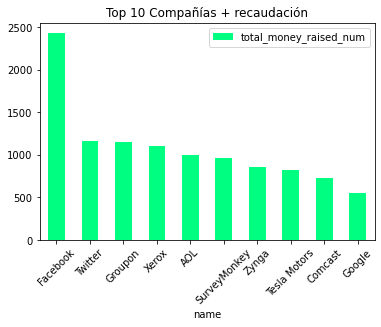

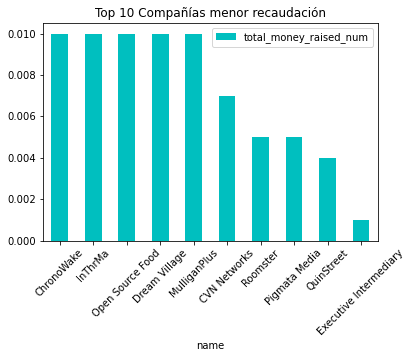

In [27]:
# Gráficas respecto a la recaudación
df_gen_com.head(10).plot(x='name', y='total_money_raised_num', kind='bar', colormap='winter_r', 
                         rot=45, title='Top 10 Compañías + recaudación');

df_gen_com.tail(10).plot(x='name', y='total_money_raised_num', kind='bar', color='c', 
                         rot=45, title='Top 10 Compañías menor recaudación');

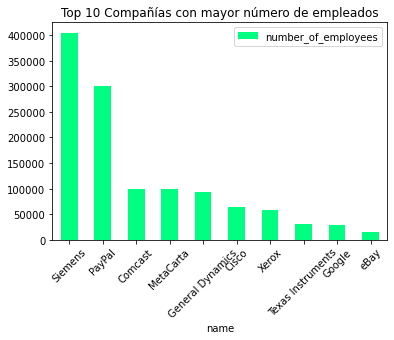

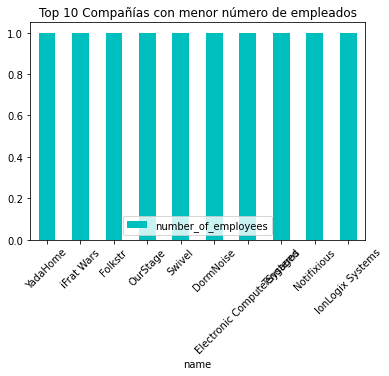

In [28]:
# Gráficas respecto al número de empleados
df_gen_com.sort_values(by=['number_of_employees'], ascending=False)\
.head(10).plot(x='name', y='number_of_employees', kind='bar', colormap='winter_r', 
                         rot=45, title='Top 10 Compañías con mayor número de empleados');

df_gen_com.sort_values(by=['number_of_employees'], ascending=False)\
.tail(10).plot(x='name', y='number_of_employees', kind='bar', color='c', 
                         rot=45, title='Top 10 Compañías con menor número de empleados');

In [29]:
# Razón número de recaudación /  num de empleados
df_gen_com['employees_money'] = df_gen_com['total_money_raised_num']/df_gen_com['number_of_employees']

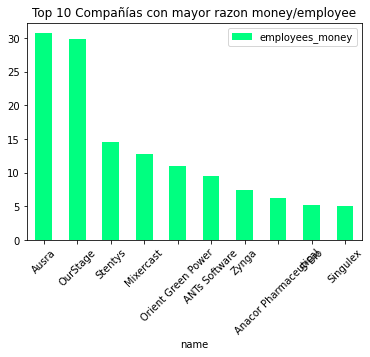

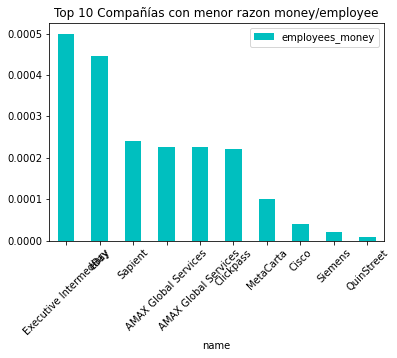

In [30]:
# Gráficas respecto a la razón
df_gen_com.sort_values(by=['employees_money'], ascending=False)\
.head(10).plot(x='name', y='employees_money', kind='bar', colormap='winter_r', 
                         rot=45, title='Top 10 Compañías con mayor razon money/employee');

df_gen_com.sort_values(by=['employees_money'], ascending=False)\
.tail(10).plot(x='name', y='employees_money', kind='bar', color='c', 
                         rot=45, title='Top 10 Compañías con menor razon money/employee');

In [123]:
df_gen_com[ df_gen_com['category_code']=='games_video']\
.sort_values(by='total_money_raised_num', ascending=False)

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised,total_money_raised_num,employees_money
589,52cdef7c4bab8bd6752981e1,Zynga,http://www.zynga.com,games_video,115,2007.0,7.0,NaN,NaN,Network of gaming applications,$860M,860.000,7.478261
1332,52cdef7c4bab8bd6752987ad,Comcast,http://comcast.com,games_video,100000,1963.0,NaN,NaN,NaN,,$725M,725.000,0.007250
1003,52cdef7c4bab8bd675298503,FriendFinder Networks,http://www.ffn.com,games_video,350,NaN,NaN,NaN,NaN,,$551M,551.000,1.574286
761,52cdef7c4bab8bd675298300,Netflix,http://www.netflix.com,games_video,2000,1997.0,NaN,NaN,NaN,Leading Internet television network,$230M,230.000,0.115000
59,52cdef7c4bab8bd675297df0,RockYou,http://www.rockyou.com,games_video,106,2005.0,11.0,NaN,NaN,Social Gaming Company,$136M,136.000,1.283019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,52cdef7d4bab8bd6752992db,IBTgames,http://www.ibtgames.com,games_video,11,2008.0,NaN,NaN,NaN,,$25k,0.025,0.002273
5447,52cdef7e4bab8bd67529a75f,Tengaged,http://tengaged.com,games_video,1,2010.0,1.0,30.0,NaN,Reality social and gaming network,$15k,0.015,0.015000
3549,52cdef7d4bab8bd675299912,Snipd,http://www.snipd.com,games_video,2,2008.0,6.0,NaN,2011.0,Quick Screenshots,$15k,0.015,0.007500
3046,52cdef7d4bab8bd675299588,Snipd,http://www.snipd.com,games_video,2,2008.0,6.0,NaN,2011.0,Quick Screenshots,$15k,0.015,0.007500


In [154]:
df_aux

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised,total_money_raised_num,employees_money
589,52cdef7c4bab8bd6752981e1,Zynga,http://www.zynga.com,games_video,115,2007.0,7.0,NaN,NaN,Network of gaming applications,$860M,860.0,7.478261
1332,52cdef7c4bab8bd6752987ad,Comcast,http://comcast.com,games_video,100000,1963.0,NaN,NaN,NaN,,$725M,725.0,0.007250
1003,52cdef7c4bab8bd675298503,FriendFinder Networks,http://www.ffn.com,games_video,350,NaN,NaN,NaN,NaN,,$551M,551.0,1.574286
761,52cdef7c4bab8bd675298300,Netflix,http://www.netflix.com,games_video,2000,1997.0,NaN,NaN,NaN,Leading Internet television network,$230M,230.0,0.115000
59,52cdef7c4bab8bd675297df0,RockYou,http://www.rockyou.com,games_video,106,2005.0,11.0,NaN,NaN,Social Gaming Company,$136M,136.0,1.283019
1523,52cdef7d4bab8bd67529893c,Kabam,http://www.kabam.com,games_video,650,2006.0,11.0,1.0,NaN,Leader in Gaming,$125M,125.0,0.192308
2498,52cdef7d4bab8bd67529914d,9You,http://9you.com,games_video,460,NaN,NaN,NaN,NaN,,$100M,100.0,0.217391
263,52cdef7c4bab8bd675297f81,hulu,http://www.hulu.com,games_video,153,2007.0,3.0,1.0,NaN,Online Video Provider,$100M,100.0,0.653595
1192,52cdef7c4bab8bd67529868c,Realtime Worlds,http://realtimeworlds.com,games_video,225,2002.0,NaN,NaN,NaN,"Entertainment software, Videogames",$82.8M,82.8,0.368000
1532,52cdef7d4bab8bd675298952,Turbine,http://www.turbine.com,games_video,200,NaN,NaN,NaN,NaN,creates and operates online games,$76.6M,76.6,0.383000


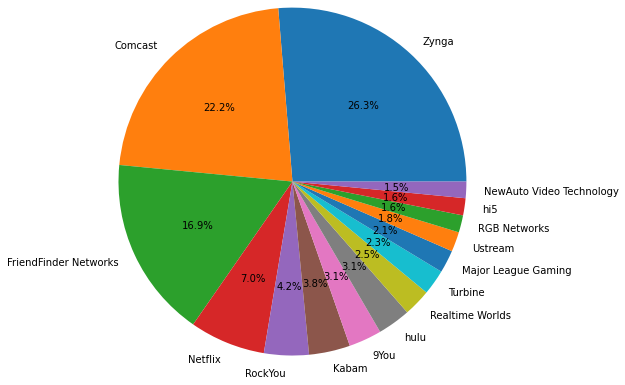

In [122]:
# Categoría Analytics
df_aux = df_gen_com[ df_gen_com['category_code']=='games_video']\
.sort_values(by='total_money_raised_num', ascending=False).head(15)

plt.pie('total_money_raised_num', data = df_aux, labels = df_aux.name, 
        autopct='%1.1f%%', radius = 2);

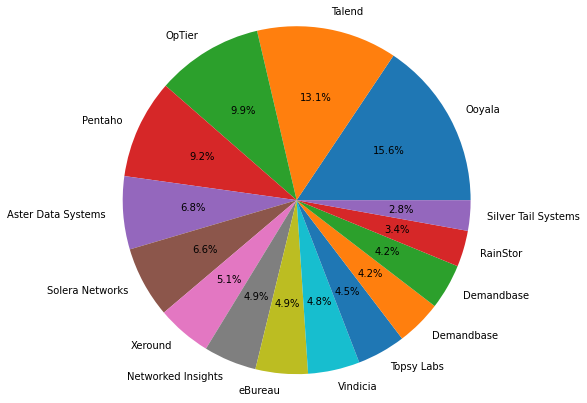

In [118]:
# Categoría Analytics
df_aux = df_gen_com[ df_gen_com['category_code']=='analytics']\
.sort_values(by='total_money_raised_num', ascending=False).head(15)

plt.pie('total_money_raised_num', data = df_aux, labels = df_aux.name, 
        autopct='%1.1f%%', radius = 2);

In [ ]:
# Categoría Analytics
df_aux = df_gen_com[ df_gen_com['category_code']=='analytics']\
.sort_values(by='total_money_raised_num', ascending=False).head(15)

plt.pie('total_money_raised_num', data = df_aux, labels = df_aux.name, 
        autopct='%1.1f%%', radius = 2);

In [31]:
# Estadísticos por categoría de compañía respecto a la recaudación 
df_category = df_gen_com.groupby('category_code').agg(
    {'total_money_raised_num':[np.sum, np.mean, np.median, np.std],
    'number_of_employees':[np.sum, np.mean, np.median, np.std]}).fillna(0)
# df_category.reset_index(inplace=True)
df_category.head()

total_money_raised_num                                 \
                                 sum        mean  median        std   
category_code                                                         
advertising                 3335.414   21.800092    9.70  35.291794   
analytics                    904.734   23.808789   10.25  29.488816   
automotive                   823.000  823.000000  823.00   0.000000   
biotech                     1590.250   69.141304   42.60  64.988685   
cleantech                   1873.600   72.061538   45.00  84.160290   

              number_of_employees                                 
                              sum        mean median         std  
category_code                                                     
advertising                 16185  105.784314   40.0  214.948891  
analytics                    2414   63.526316   40.0   79.099915  
automotive                    500  500.000000  500.0    0.000000  
biotech                       920   40.000000   28.0   40.615716  
cleantech                    4093  157.423077   68.0  219.023866

In [163]:
df_category['total_money_raised_num'].reset_index().sort_values(by=['mean'], ascending=False)


,category_code,sum,mean,median,std
2,automotive,823.0000,823.000000,823.000,0.000000
36,transportation,839.4200,167.884000,84.900,170.383967
33,social,4449.1500,153.418966,10.200,487.856427
22,nanotech,78.0000,78.000000,78.000,0.000000
4,cleantech,1873.6000,72.061538,45.000,84.160290
3,biotech,1590.2500,69.141304,42.600,64.988685
21,music,923.7300,65.980714,25.200,139.204484
13,hardware,2273.4850,59.828553,16.150,179.227735
14,health,320.6200,53.436667,28.900,60.104817
29,real_estate,212.3500,42.470000,10.200,49.611360


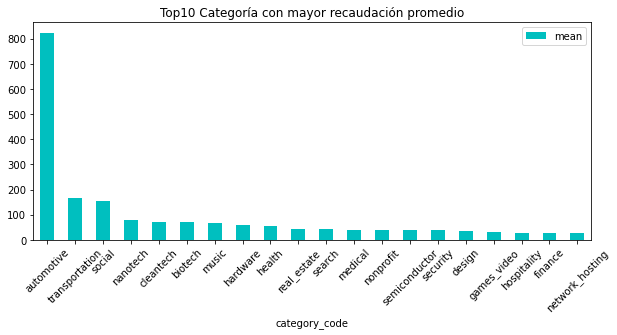

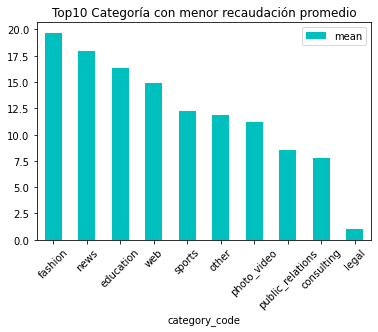

In [162]:
# Gráficas respecto catgeoría vs recaudación promedio
df_category['total_money_raised_num'].reset_index().sort_values(by=['mean'], ascending=False)\
.head(20).plot(x='category_code', y='mean', kind='bar', color='c', 
                         rot=45, title='Top10 Categoría con mayor recaudación promedio', figsize=(10,4));

df_category['total_money_raised_num'].reset_index().sort_values(by=['mean'], ascending=False)\
.tail(10).plot(x='category_code', y='mean', kind='bar', color='c', 
                         rot=45, title='Top10 Categoría con menor recaudación promedio');

## Extracción de información acerca de las oficinas

In [34]:
oficinas = colec.find({'offices':{'$not':{'$size':0}}},
                         {'name':True,'_id':0, 'offices':1})

In [35]:
data_ofi = list(oficinas)

In [36]:
df_ofi = pd.DataFrame(data_ofi)

In [37]:
lista_data_ofi = [json_normalize(i) for i in df_ofi['offices']]

<ipython-input-37-f52ae9158563>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  lista_data_ofi = [json_normalize(i) for i in df_ofi['offices']]


In [38]:
lista_nombres_ofi = list(df_ofi['name'])

In [39]:
zip_ofi = list(zip(lista_nombres_ofi, lista_data_ofi))

In [40]:
for i in zip_ofi:
    i[1]['company'] = i[0]

In [41]:
oficces = pd.DataFrame()

In [42]:
for i in range(len(zip_ofi)):
    oficces = pd.concat([oficces, zip_ofi[i][1]])

oficces.drop_duplicates(inplace=True)

In [43]:
oficces.head()

,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude,company
0,,710 - 2nd Avenue,Suite 1100,98104,Seattle,WA,USA,47.603122,-122.333253,Wetpaint
1,,270 Lafayette Street,Suite 505,10012,New York,NY,USA,40.723731,-73.996431,Wetpaint
0,Headquarters,4900 Hopyard Rd.,Suite 310,94588,Pleasanton,CA,USA,37.692934,-121.904945,AdventNet
0,Headquarters,4900 Hopyard Rd,Suite 310,94588,Pleasanton,CA,USA,37.692934,-121.904945,Zoho
0,None,135 Mississippi St,,94107,San Francisco,CA,USA,37.764726,-122.394523,Digg


In [44]:
# Filtramos el df de oficinas por las empresas del análisis
print('Total de oficinas:', oficces.shape[0])

oficces =  oficces[ oficces['company'].isin(df_gen_com.name)]
print('Total de oficinas después de filtrar:', oficces.shape[0])

Total de oficinas: 15927
Total de oficinas después de filtrar: 2632


In [45]:
df_count_ofi = oficces['company'].value_counts().to_frame()
df_count_ofi.reset_index(inplace=True)
df_count_ofi.rename(columns={'company': 'conteo', 'index':'name'}, inplace=True)
df_count_ofi.head()

,name,conteo
0,Google,67
1,ePartners,18
2,Globant,14
3,iCrossing,12
4,KIT digital,10


## Análisis del número de oficinas por cada compañía

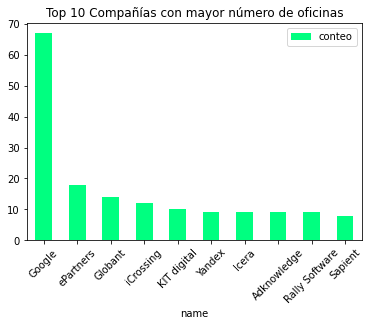

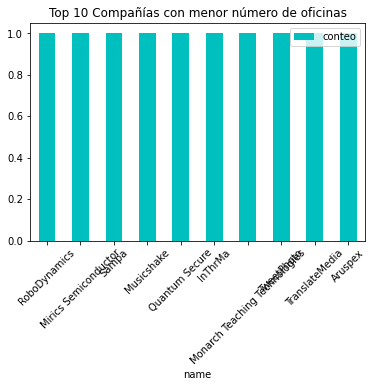

In [46]:
# Gráficas respecto a la razón
df_count_ofi.sort_values(by=['conteo'], ascending=False)\
.head(10).plot(x='name', y='conteo', kind='bar', colormap='winter_r', 
                         rot=45, title='Top 10 Compañías con mayor número de oficinas');

df_count_ofi.sort_values(by=['conteo'], ascending=False)\
.tail(10).plot(x='name', y='conteo', kind='bar', color='c', 
                         rot=45, title='Top 10 Compañías con menor número de oficinas');

In [59]:
df_gen_com[ df_gen_com['category_code']=='fashion']

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised,total_money_raised_num,employees_money
7849,52cdef7e4bab8bd67529bae7,HauteLook,http://www.hautelook.com,fashion,200,2007.0,12.0,NaN,NaN,Online Shopping Community,$41M,41.0,0.205000
3915,52cdef7d4bab8bd675299b86,Stylesight,http://www.stylesight.com,fashion,200,2004.0,NaN,NaN,NaN,SaaS Trend Forecasting Platform,$26M,26.0,0.130000
3412,52cdef7d4bab8bd6752997fc,Stylesight,http://www.stylesight.com,fashion,200,2004.0,NaN,NaN,NaN,SaaS Trend Forecasting Platform,$26M,26.0,0.130000
6006,52cdef7e4bab8bd67529ac67,Geelbe,http://www.geelbe.com,fashion,13,2008.0,10.0,1.0,NaN,Private Internet Flash Sales Club,$4.7M,4.7,0.361538
8189,52cdef7f4bab8bd67529bddf,Chicisimo,http://chicisimo.com,fashion,4,2010.0,7.0,NaN,NaN,Street fashion community,$800k,0.8,0.200000


In [64]:
df_gen_com[ df_gen_com['category_code']=='analytics']

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised,total_money_raised_num,employees_money
252,52cdef7c4bab8bd675297f72,Ooyala,http://www.ooyala.com,analytics,300,2007.0,4.0,5.0,NaN,"Video streaming, analytics, monetization",$122M,122.000,0.406667
1590,52cdef7d4bab8bd6752989e0,Talend,http://www.talend.com,analytics,400,2005.0,9.0,NaN,NaN,Open source integration software,$102M,102.000,0.255000
8561,52cdef7f4bab8bd67529c1fe,OpTier,http://www.optier.com,analytics,150,2005.0,NaN,NaN,NaN,Application Management Software,$77.5M,77.500,0.516667
832,52cdef7c4bab8bd675298379,Pentaho,http://www.pentaho.com,analytics,150,2004.0,1.0,1.0,NaN,Powerful Analytics Made Easy,$72M,72.000,0.480000
1735,52cdef7d4bab8bd675298b2b,Aster Data Systems,http://www.asterdata.com,analytics,50,2005.0,7.0,NaN,NaN,Analytic database systems,$53M,53.000,1.060000
7380,52cdef7e4bab8bd67529b74d,Solera Networks,http://www.soleranetworks.com,analytics,48,2005.0,NaN,NaN,NaN,Security Intelligence and Analytics,$51.7M,51.700,1.077083
4763,52cdef7d4bab8bd67529a25a,Xeround,http://xeround.com,analytics,40,2005.0,3.0,NaN,NaN,Cloud Database,$39.8M,39.800,0.995000
1110,52cdef7c4bab8bd6752985e7,Networked Insights,http://networkedinsights.com,analytics,130,2006.0,NaN,NaN,NaN,Marketing Decisions Platform,$38.4M,38.400,0.295385
1753,52cdef7d4bab8bd675298b4f,eBureau,http://www.ebureau.com,analytics,55,2004.0,1.0,1.0,NaN,,$38M,38.000,0.690909
1912,52cdef7d4bab8bd675298cc1,Vindicia,http://www.vindicia.com,analytics,100,2003.0,NaN,NaN,NaN,SaaS Marketing & Billing,$37.6M,37.600,0.376000


In [62]:
df_gen_com[ df_gen_com['category_code']=='automotive']

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised,total_money_raised_num,employees_money
552,52cdef7c4bab8bd675298198,Tesla Motors,http://www.teslamotors.com,automotive,500,2003.0,NaN,NaN,NaN,Electric Sport Cars,$823M,823.0,1.646


In [49]:
# Empresas en México
oficces[ oficces.country_code == 'MEX']

,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude,company
62,Google Mexico,Blvd. Manuel Avila Camacho #36,"Torre Esmeralda 2, Piso 12, Lomas de Chapultepec",1100,Mexico,None,MEX,19.507519,-99.030156,Google
3,Guadalajara,"Avenida Americas 1600, Piso 7. Colonia Country...",,44610,Guadalajara,None,MEX,NaN,NaN,Ooyala
1,Busca Corp. Tijuana,Calle Brasil No. 8471,Col. Juarez,22040,"Tijuana, B.C.",None,MEX,32.521744,-117.027495,Busca Corp
2,Busca Corp. Mexico City,Insurgentes Sur 348 Piso 9,Col. Roma,06700,Mexico City,None,MEX,19.416431,-99.165139,Busca Corp


In [50]:
df_gen_com[ df_gen_com.name.isin(oficces[ oficces.country_code == 'MEX']['company'])]

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised,total_money_raised_num,employees_money
26,52cdef7c4bab8bd675297dba,Google,http://google.com,search,28000,1998.0,9.0,7.0,NaN,,$555M,555.0,0.019821
252,52cdef7c4bab8bd675297f72,Ooyala,http://www.ooyala.com,analytics,300,2007.0,4.0,5.0,NaN,"Video streaming, analytics, monetization",$122M,122.0,0.406667
7560,52cdef7e4bab8bd67529b8db,Busca Corp,http://www.buscacorp.com,games_video,45,2007.0,2.0,NaN,NaN,Spanish-speaking Entertainment Network,$5M,5.0,0.111111


In [153]:
df_gen_com[ df_gen_com['name']=='Busca Corp']

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised,total_money_raised_num,employees_money
7560,52cdef7e4bab8bd67529b8db,Busca Corp,http://www.buscacorp.com,games_video,45,2007.0,2.0,NaN,NaN,Spanish-speaking Entertainment Network,$5M,5.0,0.111111


In [100]:
oficces[ oficces.company =='Busca Corp']

,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude,company
0,Busca Corp. USA,7590 Fay Ave. Suite 506,,92037,La Jolla,CA,USA,32.841791,-117.274602,Busca Corp
1,Busca Corp. Tijuana,Calle Brasil No. 8471,Col. Juarez,22040,"Tijuana, B.C.",None,MEX,32.521744,-117.027495,Busca Corp
2,Busca Corp. Mexico City,Insurgentes Sur 348 Piso 9,Col. Roma,06700,Mexico City,None,MEX,19.416431,-99.165139,Busca Corp


In [67]:

oficces[ oficces.company =='Pentaho']

,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude,company
0,Headquarters,Citadel International Suite 340,,32822,Orlando,FL,USA,NaN,NaN,Pentaho
1,Sales and Marketing,"201 Mission St., Suite 2375",,94105,San Francisco,CA,USA,NaN,NaN,Pentaho


## Extracción de información acerca de las competencias

In [133]:
comp = colec.find({'competitions':{'$not':{'$size':0}}}, {'name':True,'_id':0, 'competitions':1, 'competitor':1} )

data_comp = list(comp)
# data_comp

[{'name': 'Wetpaint',
  'competitions': [{'competitor': {'name': 'Wikia', 'permalink': 'wikia'}},
   {'competitor': {'name': 'JotSpot', 'permalink': 'jotspot'}},
   {'competitor': {'name': 'Socialtext', 'permalink': 'socialtext'}},
   {'competitor': {'name': 'Ning by Glam Media', 'permalink': 'ning'}},
   {'competitor': {'name': 'Soceeo', 'permalink': 'soceeo'}},
   {'competitor': {'name': 'Yola', 'permalink': 'yola'}},
   {'competitor': {'name': 'SocialGO', 'permalink': 'socialgo'}},
   {'competitor': {'name': 'IslamNor', 'permalink': 'islamnor'}}]},
 {'name': 'Zoho',
  'competitions': [{'competitor': {'name': 'Empressr',
     'permalink': 'empressr'}},
   {'competitor': {'name': 'Transmedia Corporation',
     'permalink': 'transmedia'}},
   {'competitor': {'name': 'Live Documents', 'permalink': 'livedocuments'}},
   {'competitor': {'name': 'LongJump', 'permalink': 'longjump'}},
   {'competitor': {'name': 'Phuser', 'permalink': 'phuser'}},
   {'competitor': {'name': 'NetSuite', 'perma

In [135]:
df_comp = pd.DataFrame(data_comp)
# df_comp

,name,competitions
0,Wetpaint,"[{'competitor': {'name': 'Wikia', 'permalink':..."
1,Zoho,"[{'competitor': {'name': 'Empressr', 'permalin..."
2,Digg,"[{'competitor': {'name': 'Reddit', 'permalink'..."
3,Facebook,"[{'competitor': {'name': 'MySpace', 'permalink..."
4,Omnidrive,"[{'competitor': {'name': 'Dropbox', 'permalink..."
...,...,...
4256,iGuiders,"[{'competitor': {'name': 'Hunch', 'permalink':..."
4257,MyChances,"[{'competitor': {'name': 'College Prowler', 'p..."
4258,DocASAP,"[{'competitor': {'name': 'ZocDoc', 'permalink'..."
4259,Oriact,"[{'competitor': {'name': 'BuildForge', 'permal..."


In [138]:
lista_data_comp = [json_normalize(i) for i in df_comp['competitions']]
# lista_data_comp 

<ipython-input-138-8fda85e1779a>:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  lista_data_comp = [json_normalize(i) for i in df_comp['competitions']]


[      competitor.name competitor.permalink
 0               Wikia                wikia
 1             JotSpot              jotspot
 2          Socialtext           socialtext
 3  Ning by Glam Media                 ning
 4              Soceeo               soceeo
 5                Yola                 yola
 6            SocialGO             socialgo
 7            IslamNor             islamnor,
            competitor.name competitor.permalink
 0                 Empressr             empressr
 1   Transmedia Corporation           transmedia
 2           Live Documents        livedocuments
 3                 LongJump             longjump
 4                   Phuser               phuser
 5                 NetSuite             netsuite
 6                   Google               google
 7                 Flypaper             flypaper
 8               MovingLabs           movinglabs
 9                    Ephox                ephox
 10                 Coghead              coghead
 11            

In [141]:
lista_nombres_comp = list(df_comp['name'])
# lista_nombres_comp

['Wetpaint',
 'Zoho',
 'Digg',
 'Facebook',
 'Omnidrive',
 'Postini',
 'Geni',
 'Flektor',
 'Twitter',
 'StumbleUpon',
 'Gizmoz',
 'Scribd',
 'Slacker',
 'Lala',
 'Helio',
 'eBay',
 'MeetMoi',
 'Joost',
 'Babelgum',
 'Plaxo',
 'Yahoo!',
 'Powerset',
 'Technorati',
 'SpinVox',
 'AddThis',
 'OpenX',
 'Mahalo',
 'Sparter',
 'Kyte',
 'Veoh',
 'Thoof',
 'JotSpot',
 'Meetup',
 'LifeLock',
 'Wesabe',
 'Jangl SMS',
 'SmugMug',
 'Prosper',
 'Google',
 'Jajah',
 'Skype',
 'YouTube',
 'Stickam',
 'blogTV',
 'Livestream',
 'Ustream',
 'AdaptiveBlue',
 'Intel',
 'GrandCentral',
 'delicious',
 'Topix',
 'Jobster',
 'Pownce',
 'Revision3',
 'Spock',
 'Wize',
 'SodaHead',
 'CastTV',
 'iSkoot',
 'EQO',
 'SellABand',
 'iContact',
 'blinkx',
 'Mashery',
 'Zlio',
 'Yelp',
 'Jaiku',
 'Tun3r',
 'Spotplex',
 'Yapta',
 'TripUp',
 'Wakoopa',
 'Fleck',
 'Coghead',
 'Zooomr',
 'SideStep',
 'coRank',
 'Farecast',
 'Dailymotion',
 'KickApps',
 'RockYou',
 'Pageflakes',
 'Instructables',
 'Netvibes',
 'Slide',
 'Be

In [142]:
zip_comp = list(zip(lista_nombres_comp, lista_data_comp))

In [143]:
for i in zip_comp:
    i[1]['company'] = i[0]

In [144]:
competitions = pd.DataFrame()

In [145]:
for i in range(len(zip_comp)):
    competitions = pd.concat([competitions, zip_comp[i][1]])

competitions.drop_duplicates(inplace=True)

In [146]:
competitions.head()

,competitor.name,competitor.permalink,company
0,Wikia,wikia,Wetpaint
1,JotSpot,jotspot,Wetpaint
2,Socialtext,socialtext,Wetpaint
3,Ning by Glam Media,ning,Wetpaint
4,Soceeo,soceeo,Wetpaint


In [147]:
# Filtramos por las compañías de interés
competitions = competitions[ competitions.company.isin(df_gen_com.name)]
competitions.shape[0]

3909

In [152]:
df_gen_com[df_gen_com.name.isin(competitions['competitor.name'].loc[ competitions.company == 'Ooyala'])]

,_id,name,homepage_url,category_code,number_of_employees,founded_year,founded_month,founded_day,deadpooled_year,description,total_money_raised,total_money_raised_num,employees_money
153,52cdef7c4bab8bd675297e81,Brightcove,http://www.brightcove.com,enterprise,220,2004.0,NaN,NaN,NaN,Online video platform,$103M,103.0,0.468182
352,52cdef7c4bab8bd675297ffd,Kaltura,http://corp.kaltura.com,software,160,2006.0,10.0,1.0,NaN,Open Source Video Platform,$69.1M,69.1,0.431875
2378,52cdef7d4bab8bd675299070,Extend Media,http://www.extend.com,software,62,1991.0,NaN,NaN,NaN,Information Technology,$33.2M,33.2,0.535484


In [148]:
competitions[ competitions.company == 'Ooyala']

,competitor.name,competitor.permalink,company
0,Brightcove,brightcove,Ooyala
1,Move Networks,movenetworks,Ooyala
2,VMIX Media,vmixmedia,Ooyala
3,Extend Media,extend-media,Ooyala
4,MIG69,mig69,Ooyala
5,Monetize Media,monetizemedia,Ooyala
6,Delve Networks,delve-networks,Ooyala
7,Twistage,twistage-inc,Ooyala
8,Kaltura,kaltura,Ooyala
9,DaCast,dacast,Ooyala


In [149]:
# Identificación de competidores de busca corp
competitions[ competitions.company == 'Busca Corp']

,competitor.name,competitor.permalink,company


# FOLIUM

In [164]:
oficces[ oficces.company =='Busca Corp']

,description,address1,address2,zip_code,city,state_code,country_code,latitude,longitude,company
0,Busca Corp. USA,7590 Fay Ave. Suite 506,,92037,La Jolla,CA,USA,32.841791,-117.274602,Busca Corp
1,Busca Corp. Tijuana,Calle Brasil No. 8471,Col. Juarez,22040,"Tijuana, B.C.",None,MEX,32.521744,-117.027495,Busca Corp
2,Busca Corp. Mexico City,Insurgentes Sur 348 Piso 9,Col. Roma,06700,Mexico City,None,MEX,19.416431,-99.165139,Busca Corp


In [177]:
# pip install folium
import folium

mapa2=folium.Map(location=[19.41, -99.16], tiles='stamentoner', zoom_start=12)
# mapa2=folium.Map(location=[32.52, -117.03], tiles='stamentoner', zoom_start=12)
lat = oficces['latitude'].loc[ oficces.company =='Busca Corp'].tolist()
lng = oficces['longitude'].loc[ oficces.company =='Busca Corp'].tolist()

# lat=[19.42, 19.4, 19.43, 19.39, 19.42, 19.38]
# lng=[-99.1, -99.15, -99.13 ,-99.12, -99.09, -99.11]
for i in range(len(lat)):
    folium.Marker([lat[i], lng[i]], icon=folium.Icon(color='red'),popup = '<b>Oficina Busca Corp</b>', tooltip = 'tooltip').add_to(mapa2)
    
mapa2